![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a **MSE of 3 or less on a test set**. The model you make will help the company become more efficient with their inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in the csv file
df_raw = pd.read_csv('./data/rental_info.csv',
                     parse_dates = ['rental_date', 'return_date'])
print(df_raw.shape)
print(df_raw.columns)
print(df_raw.info())
df_raw.head()

(15861, 15)
Index(['rental_date', 'return_date', 'amount', 'release_year', 'rental_rate',
       'length', 'replacement_cost', 'special_features', 'NC-17', 'PG',
       'PG-13', 'R', 'amount_2', 'length_2', 'rental_rate_2'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64          

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [3]:
df_raw['release_year'] = df_raw['release_year'].astype('int')

In [4]:
# Create "rental_length_days" col using the "return_date" and "rental_date" cols
df_raw["rental_length_days"] = df_raw["return_date"] - df_raw["rental_date"]
df_raw["rental_length_days"] = df_raw["rental_length_days"].dt.total_seconds() / (60 * 60 * 24)
df_raw.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139


In [5]:
# create deleted_scenes and behind_the_scenes cols
df_raw["deleted_scenes"] = df_raw["special_features"].apply(lambda x: 1 if "Deleted Scenes" in x else 0)
df_raw["behind_the_scenes"] = df_raw["special_features"].apply(lambda x: 1 if "Behind the Scenes" in x else 0)
df_raw.head(10)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.865278,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.836806,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7.238889,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2.100000,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.045139,0,1
5,2005-05-29 16:51:44+00:00,2005-06-01 21:43:44+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.202778,0,1
6,2005-06-17 19:42:42+00:00,2005-06-22 20:39:42+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,5.039583,0,1
7,2005-07-09 18:23:46+00:00,2005-07-13 19:04:46+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4.028472,0,1
8,2005-07-27 13:16:28+00:00,2005-07-28 13:40:28+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,1.016667,0,1
9,2005-08-21 13:53:52+00:00,2005-08-25 09:03:52+00:00,2.99,2005,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3.798611,0,1


In [6]:
print(df_raw['rental_rate'].value_counts().sort_index())
print(df_raw['replacement_cost'].value_counts().sort_index())

rental_rate
0.99    5582
2.99    5061
4.99    5218
Name: count, dtype: int64
replacement_cost
9.99      678
10.99     712
11.99     738
12.99     852
13.99     789
14.99     809
15.99     555
16.99     631
17.99     681
18.99     683
19.99     653
20.99     853
21.99     903
22.99    1033
23.99     683
24.99     627
25.99     730
26.99     730
27.99     950
28.99     709
29.99     862
Name: count, dtype: int64


## Data leakage

+ The `amount` is determined ***after*** the DVD has been returned. In other word, `amount` is determined by the target `rental_length_days` and not the other way around therefore the `amount` feature *leaks* information about the target (`rental_length_days`), so it should **NOT** be used as a predictor.
+ For the same reason that `amount` should not be used, `amount_2` (the square of `amount`) should not be used either.
+ tbd

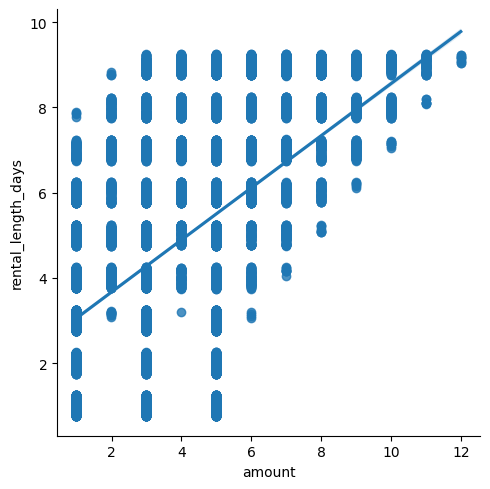

In [7]:
# fig, ax = plt.subplots()

# ax.scatter(x = df_raw['amount'], y=df_raw['rental_length_days'], alpha=0.05)
# ax.set_xlabel('amount of rental (assumed $)')
# ax.set_ylabel('rental length (days)')

sns.lmplot(data=df_raw, x='amount', y='rental_length_days')
plt.show()

In [8]:
# create feature matrix
all_feature_cols = ['rental_rate', 'rental_rate_2', 'release_year', 'length', 'length_2',
                    'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 'deleted_scenes', 'behind_the_scenes']
X = df_raw[all_feature_cols]
# specify the target
y = df_raw['rental_length_days']

In [9]:
# split into train and test sets
SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=SEED)
print(f"Training feature matrix shape: {X_train.shape}, Testing feature matrix shape: {X_test.shape}")
print(f"Training target vector shape: {y_train.shape}, Testing target vector shape: {y_test.shape}")

Training feature matrix shape: (12688, 12), Testing feature matrix shape: (3173, 12)
Training target vector shape: (12688,), Testing target vector shape: (3173,)


In [10]:
# try a random forest, first w/o any hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor()  # start with default hyperparameters
# fit on training set
rf_base.fit(X_train, y_train)
# predict on test set
y_pred = rf_base.predict(X_test)
# initial MSE
mse_rf_default = mean_squared_error(y_test, y_pred)
print(f"Test set MSE onf rf with default hypers: {mse_rf_default:.2f}")

Test set MSE onf rf with default hypers: 7.38


## Variable importance

The initial MSE using Random Forest defaults is way too high, but before we diving into hyperparamenter tuning, let's check out the variable importance to see what is contributing the most/least to the model performance.

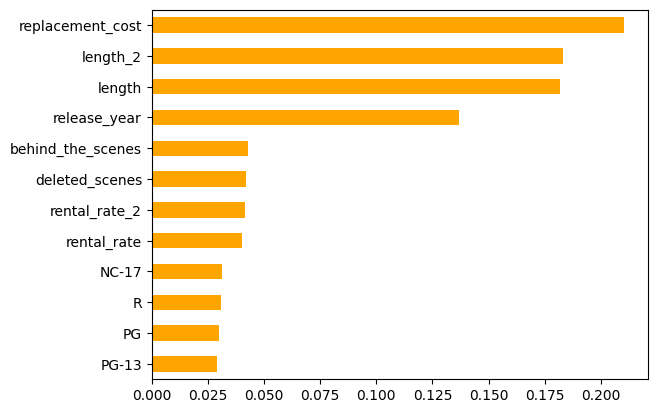

In [11]:
rf_feature_importances = pd.Series(rf_base.feature_importances_, index=X.columns)
rf_feature_importances_sorted = rf_feature_importances.sort_values()
rf_feature_importances_sorted.plot(kind='barh', color='orange')
plt.show()

## Random Forest Hyperparameter Tuning